In [1]:
from neuron import h
from stellatecell import StellateCell
from interneuron import Interneuron
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft , signal, fftpack
h.load_file('stdrun.hoc')

1.0

The MEC network motif (from Arun Neru and Collins Assisi 2019)
https://www.biorxiv.org/content/10.1101/545822v1

In [2]:
#####create cells, setup synapses#####
h.celsius=37

#create cells
stell_cell1 = StellateCell(0,0,0,0,0)
stell_cell1.soma.insert('stellate_mech')

stell_cell2 = StellateCell(1,5,0,0,0)
stell_cell2.soma.insert('stellate_mech')

intrnrn1 = Interneuron(2,0,-12,0,0)
intrnrn1.soma.insert('naf')
intrnrn1.soma.insert('kdr')
intrnrn1.soma.insert('pas')
intrnrn1.soma.insert('i_theta')

for seg in intrnrn1.soma:
    seg.pas.g=1e-4
    seg.pas.e = -65
    
intrnrn2 = Interneuron(3,5,-12,0,0)
intrnrn2.soma.insert('naf')
intrnrn2.soma.insert('kdr')
intrnrn2.soma.insert('pas')
intrnrn2.soma.insert('i_theta')

for seg in intrnrn2.soma:
    seg.pas.g=1e-4
    seg.pas.e = -65

cells = [[intrnrn1, intrnrn2], [stell_cell1, stell_cell2]]

    
#####setup syanpses#####

#inihibitory synapses
inhb_syn1 = h.fvpre(stell_cell1.soma(0)) 
h.setpointer(intrnrn1.soma(1)._ref_v, 'vpre', inhb_syn1)

inhb_syn2 = h.fvpre(stell_cell2.soma(0))
h.setpointer(intrnrn2.soma(1)._ref_v, 'vpre', inhb_syn2) 

inhb_syn3 = h.fvpre(intrnrn1.soma(0))
h.setpointer(intrnrn2.soma(1)._ref_v, 'vpre', inhb_syn3) 

inhb_syn4 = h.fvpre(intrnrn2.soma(0))
h.setpointer(intrnrn1.soma(1)._ref_v, 'vpre', inhb_syn4) 

inhb_syn=[[inhb_syn1,inhb_syn2],[inhb_syn3,inhb_syn4]]

#inhibitory synaptic conductances
for stell,mutual in zip(inhb_syn[0],inhb_syn[1]):
    stell.gmax =2e-4
    mutual.gmax=4e-4
#inhibitory synaptic rate constants
h.alpha_fvpre=3.33
h.beta_fvpre=0.05


#excitatory synapses
exc_syn1 = h.stell_syn(intrnrn2.soma(0))
h.setpointer(stell_cell1.soma(1)._ref_v, 'vpre', exc_syn1) 
exc_syn2 = h.stell_syn(intrnrn1.soma(0))
h.setpointer(stell_cell2.soma(1)._ref_v, 'vpre', exc_syn2) 

#excitatory synaptic parameters
exc_syn1.gsynbar=exc_syn2.gsynbar=0.12e-4
exc_syn1.asyn=exc_syn2.asyn=10
exc_syn1.bsyn=exc_syn2.bsyn=3.3e-2

#netcons to measure spike times

stell_netc1 = h.NetCon(stell_cell1.soma(0.5)._ref_v,None,sec=stell_cell1.soma)
stell_netc2 = h.NetCon(stell_cell2.soma(0.5)._ref_v,None,sec=stell_cell2.soma)
int_netc1 = h.NetCon(intrnrn1.soma(0.5)._ref_v,None,sec=intrnrn1.soma)
int_netc1.threshold=0
int_netc2 = h.NetCon(intrnrn2.soma(0.5)._ref_v,None,sec=intrnrn2.soma)
int_netc2.threshold=0

netcons = [int_netc1,int_netc2,stell_netc1,stell_netc2]



In [4]:
#####Instrumentaion#####

sim_dur=2000

#stellate hyperpolarizing current, Ia, constant 
stell_ia1 = h.IClamp(stell_cell1.soma(0.5))
stell_ia1.amp = -2.3e-3
stell_ia1.dur = sim_dur


stell_ia2 = h.IClamp(stell_cell2.soma(0.5))
stell_ia2.amp = -2.3e-3
stell_ia2.dur = sim_dur
stell_ia1.delay = 10



#interneuron depolarizing current, Iext 
I_ext_interneuron1 = h.IClamp(intrnrn1.soma(0.5))
I_ext_interneuron1.amp = 8e-5 #<-switch at 5.8e-4 nA
I_ext_interneuron1.dur = sim_dur

I_ext_interneuron2 = h.IClamp(intrnrn2.soma(0.5))
I_ext_interneuron2.amp = 8e-5
I_ext_interneuron2.dur = sim_dur



#vectors for recording
stell_v1 = h.Vector().record(stell_cell1.soma(0.5)._ref_v)
stell_v2 = h.Vector().record(stell_cell2.soma(0.5)._ref_v)
int_v1 = h.Vector().record(intrnrn1.soma(0.5)._ref_v)
int_v2 = h.Vector().record(intrnrn2.soma(0.5)._ref_v)
int_theta_vec = h.Vector().record(intrnrn1.soma(0.5).i_theta._ref_itheta)
int_theta_vec2 = h.Vector().record(intrnrn2.soma(0.5).i_theta._ref_itheta)
int_na_vec = h.Vector().record(intrnrn1.soma(0.5)._ref_ina)
int_ik_vec = h.Vector().record(intrnrn1.soma(0.5)._ref_ik)

t = h.Vector().record(h._ref_t)

#vectors for recording spiketimes
spiketimes = [h.Vector() for nc in netcons]
for nc,vec in zip(netcons,spiketimes):
    nc.record(vec)
    





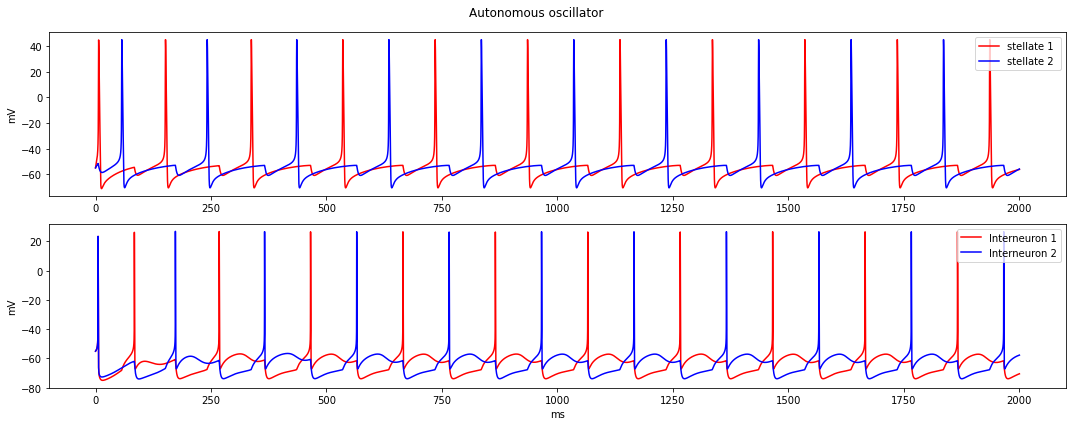

In [5]:
#####simulation#####
#autonmous oscillator#
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(2,1,figsize=(15,6))
axs[0].plot(t,stell_v1,color='red', label='stellate 1')
axs[0].plot(t,stell_v2,color='blue', label = 'stellate 2 ')
axs[1].plot(t,int_v1,color='red', label='Interneuron 1')
axs[1].plot(t,int_v2,color='blue', label='Interneuron 2')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[1].set_xlabel('ms')

axs[0].set_ylabel('mV')
axs[1].set_ylabel('mV')

fig.suptitle('Autonomous oscillator')

fig.tight_layout()

In [6]:
####switch state#####
I_ext_interneuron1.amp = 5.8e-4
I_ext_interneuron2.amp = 5.8e-4

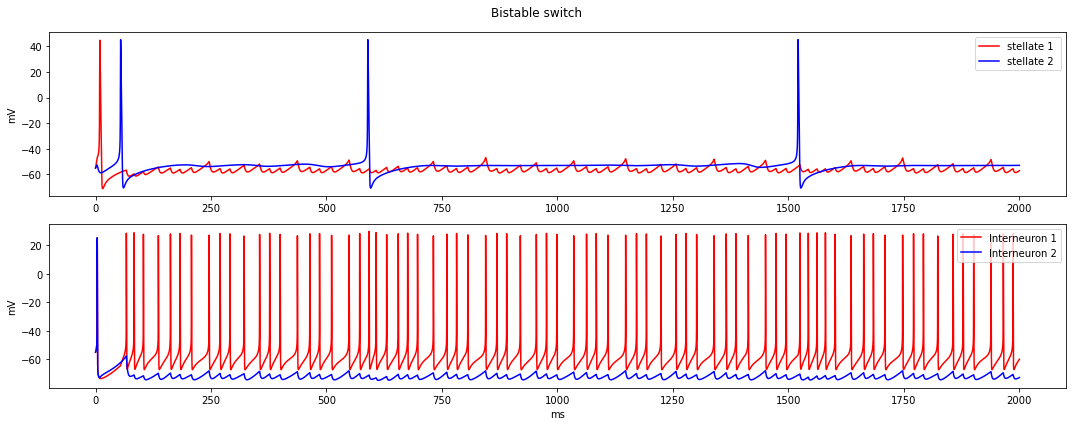

In [7]:
#####simulation#####
#bistable switch#
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(2,1,figsize=(15,6))
axs[0].plot(t,stell_v1,color='red', label='stellate 1')
axs[0].plot(t,stell_v2,color='blue', label = 'stellate 2 ')
axs[1].plot(t,int_v1,color='red', label='Interneuron 1')
axs[1].plot(t,int_v2,color='blue', label='Interneuron 2')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[1].set_xlabel('ms')

axs[0].set_ylabel('mV')
axs[1].set_ylabel('mV')

fig.suptitle('Bistable switch')

fig.tight_layout()


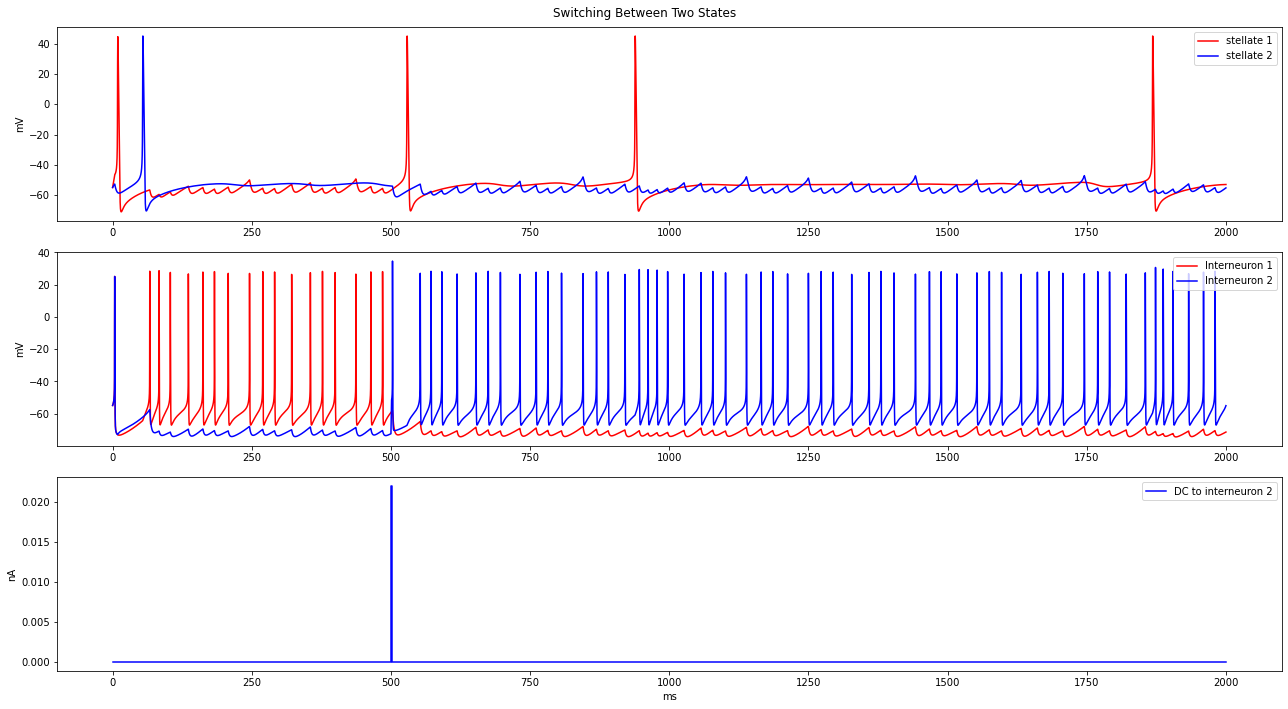

In [8]:
#####add dc to interneuron 2 at 500ms#####
int_dc = h.IClamp(intrnrn2.soma(0.5))
int_dc.amp = 0
int_dc.dur = sim_dur

dc_curr = h.Vector([0,0,0.022,0.022,0,0])
dc_curr_t = h.Vector([0,500,500,501,501,sim_dur])
dc_curr.play(int_dc._ref_amp,dc_curr_t,True)




#####simulation#####
#switching between two states#
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(3,1,figsize=(18,10))
p1=axs[0].plot(t,stell_v1,color='red',label='stellate 1')
p2=axs[0].plot(t,stell_v2,color='blue',label='stellate 2')
p3=axs[1].plot(t,int_v1,color='red',label='Interneuron 1')
p4=axs[1].plot(t,int_v2,color='blue',label='Interneuron 2')
p6=axs[2].step(list(dc_curr_t),list(dc_curr),color='blue',label='DC to interneuron 2',where='post')

for ax in axs:
    ax.legend(loc='upper right')
axs[0].set_ylabel('mV')
axs[1].set_ylabel('mV')
axs[2].set_ylabel('nA')
axs[2].set_xlabel('ms')
fig.suptitle('Switching Between Two States')
fig.tight_layout()

In [9]:
#####Adding noise####
ingauss1 = h.InGauss(intrnrn1.soma(0))
ingauss1.dur= sim_dur
ingauss1.stdev=0.01 
ingauss2 = h.InGauss(intrnrn2.soma(0))
ingauss2.dur= sim_dur
ingauss2.stdev=0.01


int_dc=None #remove DC current

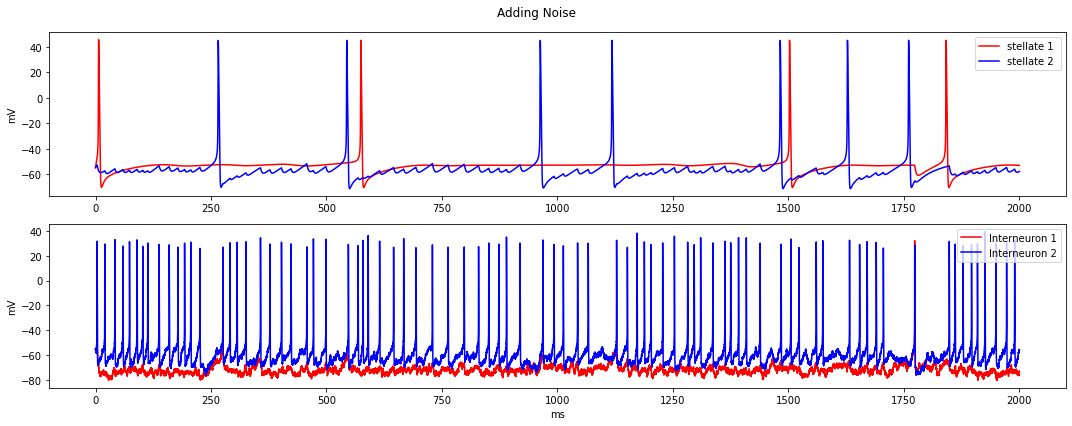

In [14]:
#####simulation######Inoise###
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(2,1,figsize=(15,6))
axs[0].plot(t,stell_v1,color='red', label='stellate 1')
axs[0].plot(t,stell_v2,color='blue', label = 'stellate 2 ')
axs[1].plot(t,int_v1,color='red', label='Interneuron 1')
axs[1].plot(t,int_v2,color='blue', label='Interneuron 2')


axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[1].set_xlabel('ms')
axs[0].set_ylabel('mV')
axs[1].set_ylabel('mV')
fig.suptitle('Adding Noise')

fig.tight_layout()